<a href="https://colab.research.google.com/github/lhiwi/credit-risk-model/blob/task-5/notebooks/model-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

model-training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install mlflow category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import mlflow
import category_encoders as ce
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
data_path = '/content/drive/MyDrive/Data_5/Data/features_with_label.csv'
df = pd.read_csv(data_path)
print("Data shape:", df.shape)
df.head()

Data shape: (3742, 26)


,Recency,Frequency,Monetary,CustomerId,hour,day,month,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,...,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,cluster,is_high_risk
0,1.937605,-0.253459,-0.089524,CustomerId_1,16.000000,21.000000,11.000000,1,0,0,...,0,1,0,0,0,0,0,1,0,1
1,1.937605,-0.253459,-0.089524,CustomerId_10,16.000000,21.000000,11.000000,1,0,0,...,0,1,0,0,0,0,0,1,0,1
2,2.158882,-0.212186,-0.082011,CustomerId_1001,7.800000,16.000000,11.000000,2,0,3,...,0,2,3,0,0,0,5,0,0,1
3,-0.201408,-0.150278,-0.091448,CustomerId_1002,13.454545,14.727273,8.636364,5,0,6,...,0,6,5,0,0,0,6,5,2,0
4,-0.717722,-0.201868,-0.081422,CustomerId_1003,14.333333,1.000000,2.000000,3,0,3,...,0,2,4,0,0,0,6,0,2,0


In [22]:
FEATURE_COLS = [c for c in df.columns if c not in ['CustomerId','is_high_risk']]
X = df[FEATURE_COLS]
y = df['is_high_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2993, 24) Test shape: (749, 24)


logisic regression pipeline with woe

In [23]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr = LogisticRegression(max_iter=1000, random_state=42)
grid_lr = GridSearchCV(
    lr, param_grid, scoring='roc_auc', cv=5, n_jobs=-1
)
grid_lr.fit(X_train_scaled, y_train)

print("Best LR params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_


Best LR params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


Gradient boosting pipeline

In [24]:
# Hyperparameter distributions for random search
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 50, 100]
}

gbm = HistGradientBoostingClassifier(random_state=42)
rand_gbm = RandomizedSearchCV(
    gbm, param_dist, n_iter=10,
    scoring='roc_auc', cv=3, random_state=42, n_jobs=-1
)
rand_gbm.fit(X_train, y_train)

print("Best GBM params:", rand_gbm.best_params_)
best_gbm = rand_gbm.best_estimator_


Best GBM params: {'min_samples_leaf': 100, 'max_depth': 7, 'learning_rate': 0.01}


Evaluation and ROC curves

--- Logistic Regression ---
ROC-AUC:    1.0
Precision:  1.0
Recall:     1.0
F1 Score:   1.0
--- Gradient Boosting ---
ROC-AUC:    1.0
Precision:  1.0
Recall:     1.0
F1 Score:   1.0


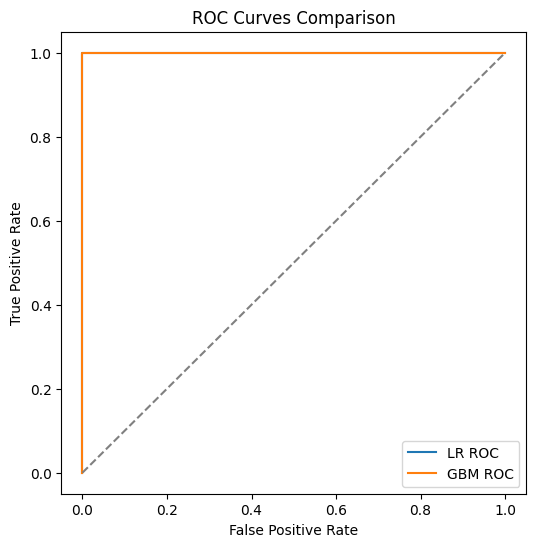

In [25]:
# Define evaluation helper (if not already present)
def evaluate(model, X_tr, y_tr, X_te, y_te, name):
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    print(f"--- {name} ---")
    print("ROC-AUC:   ", roc_auc_score(y_te, y_proba))
    print("Precision: ", precision_score(y_te, y_pred))
    print("Recall:    ", recall_score(y_te, y_pred))
    print("F1 Score:  ", f1_score(y_te, y_pred))

# Plot ROC curves
plt.figure(figsize=(6,6))

# Logistic Regression on scaled features
evaluate(
    best_lr,
    X_train_scaled, y_train,
    X_test_scaled,  y_test,
    "Logistic Regression"
)

# Gradient Boosting on raw features
evaluate(
    best_gbm,
    X_train, y_train,
    X_test,  y_test,
    "Gradient Boosting"
)

# Draw chance line
fpr, tpr, _ = roc_curve(y_test, best_lr.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label="LR ROC")
fpr_g, tpr_g, _ = roc_curve(y_test, best_gbm.predict_proba(X_test)[:, 1])
plt.plot(fpr_g, tpr_g, label="GBM ROC")

plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()


log to Mlflow

In [27]:
mlflow.set_experiment("CreditRiskModels")

# Log Logistic Regression run
with mlflow.start_run(run_name="LogisticRegression"):
    mlflow.log_params(grid_lr.best_params_)
    lr_proba = best_lr.predict_proba(X_test_scaled)[:, 1]
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, lr_proba))
    mlflow.sklearn.log_model(best_lr, "model")

# Log Gradient Boosting run
with mlflow.start_run(run_name="GradientBoosting"):
    mlflow.log_params(rand_gbm.best_params_)
    gbm_proba = best_gbm.predict_proba(X_test)[:, 1]
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, gbm_proba))
    mlflow.sklearn.log_model(best_gbm, "model")

print("Logged both models to MLflow under experiment 'CreditRiskModels'.")


2025/07/02 01:28:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 01:28:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/02 01:28:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 01:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged both models to MLflow under experiment 'CreditRiskModels'.
